In [5]:
import numpy as np
import timeit
import os
import pickle
from PIL import Image, ImageDraw

%run utils.ipynb
%run kernel.ipynb

Match score over image "dataset/dataset_source_101_ObjectCategories_yin_yang_image_0033@67,67.png" = 0.043937575030012006


In [6]:
class KernelGrid:
    def __init__(self, grid_size):
        super()
        self.size = grid_size
        self.fence_kernel = FenceKernel(0) # empty kernel
        self.indices = dict()

    def __eq__(self, other): 
        if not isinstance(other, KernelGrid):
            return NotImplemented

        return self.size == other.size and self.indices == other.indices

    @classmethod
    def random_nog(cls, config):
        g = cls(config.grid_size)
        
        for i in range(g.size):
            for j in range(g.size):
                kernel = Kernel.random_nog(config)
                g.indices[(i, j)] = kernel
                
        return g

    @classmethod
    def random(cls, config):
        g = cls(config.grid_size)
        
        for i in range(g.size):
            for j in range(g.size):
                kernel = Kernel.random(config)
                g.indices[(i, j)] = kernel
                
        return g

    @classmethod
    def from_kernels(cls, kernels):
        assert len(kernels) == 2
        assert len(kernels[0]) == len(kernels[1])
        assert len(kernels[0]) > 0

        g = cls(len(kernels[0]))
        
        for i in range(g.size):
            for j in range(g.size):
                kernel = kernels[i][j]
                g.indices[(i, j)] = kernel
                
        return g

    def run_image_st(self, img, kernel_score_threshold):
        # singlethreaded
        matched_kernels = []
        indices_items = self.indices.items()
        
        for ij, k in indices_items:
            score = k.apply(img, 8)
            # print(f'kms@ {ij} {score}')
            
            if score >= kernel_score_threshold:
                matched_kernels.append((ij, k))

            self.get_neighbours(ij)

        return len(matched_kernels) / len(indices_items)

    def run_image_mt(self, img, kernel_score_threshold):
        # multithreaded (if ever needed)
        assert False

    def get_neighbours(self, node_indices):
        def _gn(off_i, off_j):
            neighbour_indices = node_indices[0] + off_i, node_indices[1] + off_j
            
            if any(map(lambda ni: ni < 0 or ni >= self.size, neighbour_indices)):
                # print(f'kms@ fence {neighbour_indices}')
                return neighbour_indices, self.fence_kernel

            # print('kms@ normal')
            return neighbour_indices, self.indices[neighbour_indices]

        # Order: l, lt, t, rt, r, rb, b, lb
        return (\
            _gn(-1, 0),
            _gn(-1, 1),
            _gn(0, 1),
            _gn(1, 1),
            _gn(0, 1),
            _gn(1, -1),
            _gn(0, -1),
            _gn(-1, -1)
        )

    def get_kernel_images(self, out_dims=1):
        assert out_dims in [1, 2]
        images = []
        
        for i in range(self.size):
            acc = [] if out_dims == 2 else images
            
            for j in range(self.size):
                k = self.indices[(i,j)]
                acc.append(k.to_image(inverted=False))

            if out_dims == 2:
                images.append(acc)

        return images                

In [7]:
my_config = Config()
kernels1 = [
    [horz_line_kernel, shifted_horz_line_kernel],
    [vert_line_kernel, shifted_vert_line_kernel],
]
kernels2 = [
    [vert_line_kernel, shifted_vert_line_kernel],
    [horz_line_kernel, shifted_horz_line_kernel],
]
grid1 = KernelGrid.from_kernels(kernels1)
grid2 = KernelGrid.from_kernels(kernels2)
assert grid1 != grid2
grid1_ser = pickle.dumps(grid1)
grid1_loaded = pickle.loads(grid1_ser)
assert grid1 == grid1_loaded


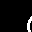
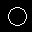
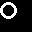
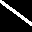
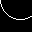
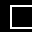
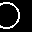
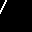
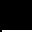
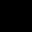
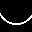
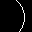
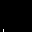
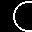
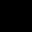
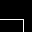
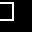
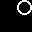
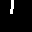
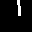
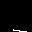
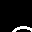
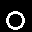
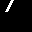
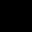
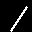
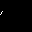
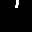
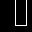
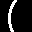
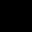
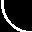
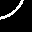
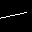
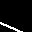
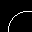
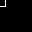
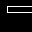
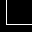
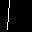
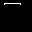
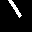
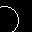
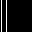
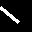
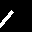
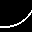
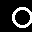
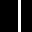
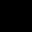
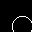
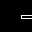
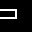
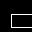
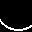
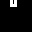
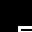
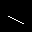
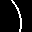
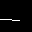
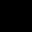
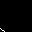
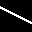
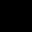
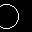
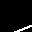
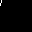
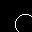
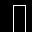
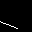
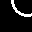
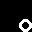
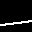
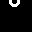
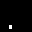
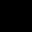
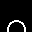
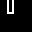
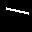
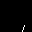
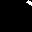
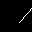
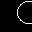
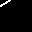
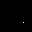
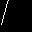
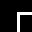
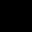
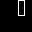
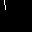
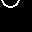
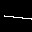
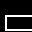
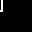
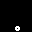
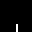
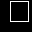
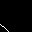
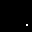
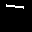
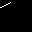
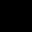
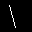
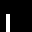
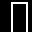
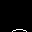
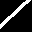
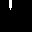
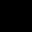
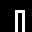
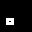
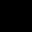
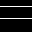
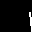
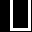
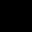
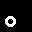
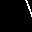
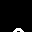
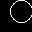
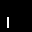
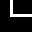
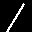
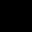
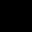
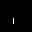
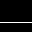
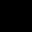
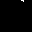
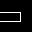
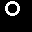
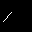
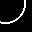
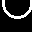
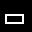
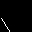
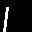
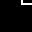
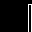
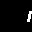
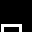
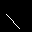
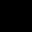
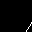
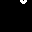
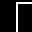
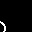
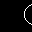
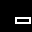
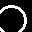
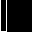
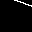
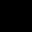
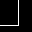
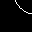
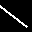
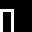
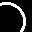
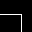
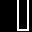
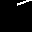
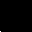
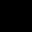
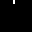
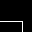
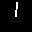
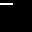
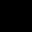
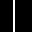
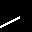
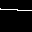
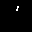
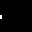
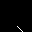
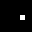
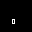
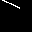
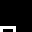
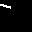
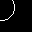
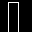
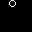
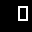
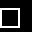
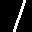
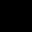
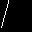
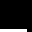
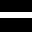
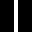
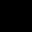
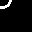
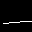
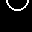
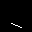
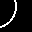
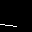
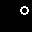
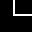
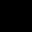
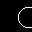
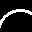
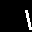
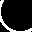
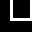
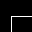
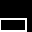
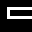
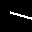
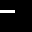
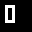
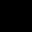
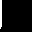
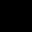
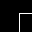
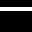
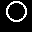
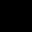
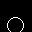
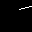
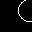
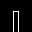
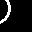
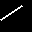
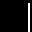
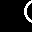
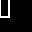
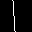
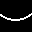
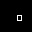
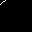
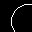
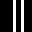
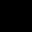
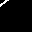
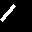
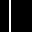
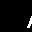
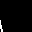
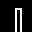
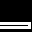
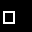
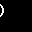
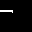
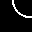
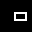
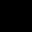
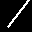
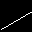
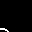
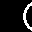
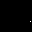
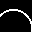
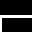
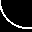
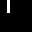

In [8]:
my_config = Config()
grid = KernelGrid.random(my_config)
display_images_grid(grid.get_kernel_images(1), grid.size)

In [9]:
%time
my_config = Config()
KernelGrid.random_nog(my_config).run_image_st(z, my_config.kernel_score_threshold)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.05 μs


NameError: name 'config' is not defined